## Predikcija slova znakovnog jezika

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

Prikaz prikaz prvih **5** redova **trening** skupa:

In [2]:
train_data = pd.read_csv("../projekat/data/sign_mnist_train/sign_mnist_train.csv")
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Kolona **label** oznacava slovo koje je opisano cifrom od **0** do **24**, dok se slika sastoji od **784 px**.



In [3]:
y_train = train_data['label'] #slova
x_train = train_data.drop(["label"],axis=1) #slika

Distribucija klasa (slova) u koloni label:

Text(0.5, 1.0, 'Ukupan broj svakog slova u trening skupu')

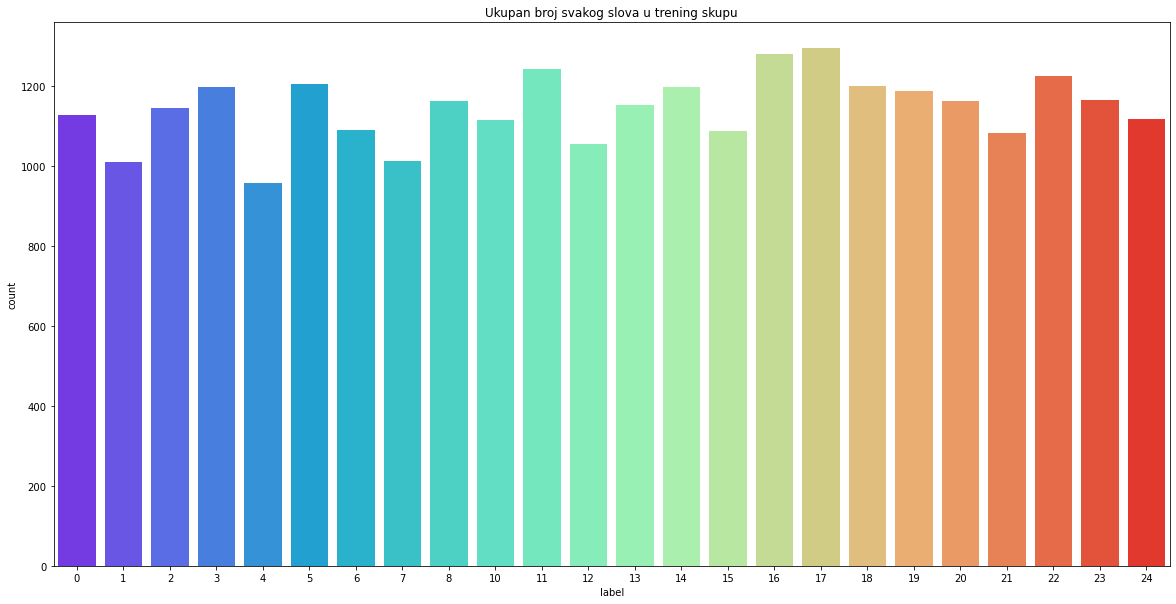

In [4]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(20,10))
g = sns.countplot(y_train, palette="rainbow")
plt.title("Ukupan broj svakog slova u trening skupu")

Ucitavanje prve cetiri slike:

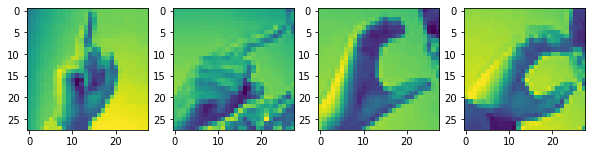

In [5]:
f, ax = plt.subplots(1,4)
f.set_size_inches(10,10)

k = 0
for i in range(1):
    for j in range(4):
        img = x_train.iloc[k].to_numpy()
        img = img.reshape((28,28))
        ax[j].imshow(img)
        k += 1

#### Klasifikacija

* oznake klasa cemo enkodirati pomocu [**Label Binazier-a**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)



* potom se vrsi grayscale normalizacija 



* zatim pretvaranje u 3D matricu (1 zasto sto je grayscale pa korsiti samo jedan kanal).

In [6]:
from sklearn.preprocessing import LabelBinarizer

In [7]:
label_binrizer = LabelBinarizer()
y_train = label_binrizer.fit_transform(y_train)

# normalization
x_train = x_train/255.0

# reshape
x_train = x_train.values.reshape(-1,28,28,1)

Ucitavamo testne podatke i preprocesiramo ih (isto kao i trening):

In [8]:
test_data = pd.read_csv("../projekat/data/sign_mnist_test/sign_mnist_test.csv")
y_test = test_data['label']
x_test = test_data.drop(["label"],axis=1)

label_binrizer = LabelBinarizer()
y_test = label_binrizer.fit_transform(y_test)

x_test = x_test/255.0

x_test = x_test.values.reshape(-1,28,28,1)

#### Neuronska mreza

Kao klasifikator koristi se neuronska mreza sa 3 konvoluciona sloja.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D

In [24]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPool2D(pool_size = (2, 2)))
# convolutional layer 
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
# convolutional layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(24, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Vizuelizacija modela sa brojem parametara koje je potrebno "istrenirati".

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

Prilikom treninranja koristi se [**ModelCheckpoint**](https://keras.io/api/callbacks/model_checkpoint/) koji cuva model nakon svake epohe, ali u ovom slucaju ce cuvati samo poslednji.

In [12]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", verbose=1, save_best_only=True) 

start = datetime.now()
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/15
215/215 [==============================] - 70s 314ms/step - loss: 2.7097 - accuracy: 0.1794 - val_loss: 1.1770 - val_accuracy: 0.6062

Epoch 00001: val_loss improved from inf to 1.17703, saving model to models\best_weights.hdf5
Epoch 2/15
215/215 [==============================] - 60s 281ms/step - loss: 0.9036 - accuracy: 0.6986 - val_loss: 0.6624 - val_accuracy: 0.7692

Epoch 00002: val_loss improved from 1.17703 to 0.66242, saving model to models\best_weights.hdf5
Epoch 3/15
215/215 [==============================] - 62s 289ms/step - loss: 0.4395 - accuracy: 0.8537 - val_loss: 0.4322 - val_accuracy: 0.8606

Epoch 00003: val_loss improved from 0.66242 to 0.43221, saving model to models\best_weights.hdf5
Epoch 4/15
215/215 [==============================] - 72s 337ms/step - loss: 0.2302 - accuracy: 0.9290 - val_loss: 0.3625 - val_accuracy: 0.8992

Epoch 00004: val_loss improved from 0.43221 to 0.36252, saving model to models\best_weights.hdf5
Epoch 5/15
215/215 [============

In [13]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])


test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

858/858 [==============================] - 31s 36ms/step - loss: 6.6619e-04 - accuracy: 1.0000
Training Accuracy:  1.0
225/225 [==============================] - 8s 37ms/step - loss: 0.3618 - accuracy: 0.9211
Test Accuracy:  0.9210819602012634


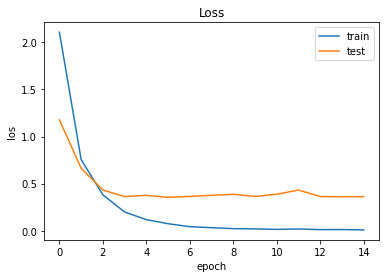

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('los')
plt.legend(['train','test'])

plt.show()

Kako se **loss** ne smanjuje to znači da je **learnig rate** mali, pa ce se povecati na 0.001.

In [25]:
from keras.optimizers import Adam

opt = Adam(learning_rate=1e-3)
model.load_weights(filepath="models/best_weights.hdf5")
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = opt)

In [18]:
history= model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/15
215/215 [==============================] - 70s 317ms/step - loss: 0.0681 - accuracy: 0.9802 - val_loss: 0.3409 - val_accuracy: 0.9066

Epoch 00001: val_loss improved from 0.35466 to 0.34086, saving model to models\best_weights.hdf5
Epoch 2/15
215/215 [==============================] - 63s 291ms/step - loss: 0.0366 - accuracy: 0.9907 - val_loss: 0.3843 - val_accuracy: 0.9062

Epoch 00002: val_loss did not improve from 0.34086
Epoch 3/15
215/215 [==============================] - 75s 350ms/step - loss: 0.0257 - accuracy: 0.9930 - val_loss: 0.3450 - val_accuracy: 0.9137

Epoch 00003: val_loss did not improve from 0.34086
Epoch 4/15
215/215 [==============================] - 63s 293ms/step - loss: 0.0214 - accuracy: 0.9944 - val_loss: 0.4044 - val_accuracy: 0.9105

Epoch 00004: val_loss did not improve from 0.34086
Epoch 5/15
215/215 [==============================] - 76s 356ms/step - loss: 0.0153 - accuracy: 0.9961 - val_loss: 0.3635 - val_accuracy: 0.9267

Epoch 00005: val_los

In [19]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])


test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

858/858 [==============================] - 30s 35ms/step - loss: 1.4550e-04 - accuracy: 1.0000
Training Accuracy:  1.0
225/225 [==============================] - 8s 35ms/step - loss: 0.4102 - accuracy: 0.9314 2s
Test Accuracy:  0.9313998818397522


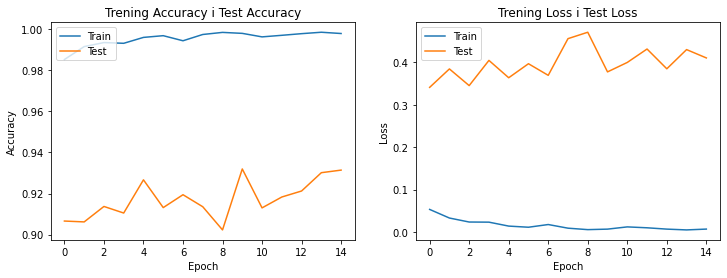

In [20]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Test Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Test Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [26]:
start = datetime.now()
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)


Epoch 1/15
172/172 [==============================] - 68s 382ms/step - loss: 0.0491 - accuracy: 0.9853 - val_loss: 0.0085 - val_accuracy: 0.9996

Epoch 00001: val_loss improved from 0.34086 to 0.00847, saving model to models\best_weights.hdf5
Epoch 2/15
172/172 [==============================] - 65s 377ms/step - loss: 0.0305 - accuracy: 0.9915 - val_loss: 0.0120 - val_accuracy: 0.9973

Epoch 00002: val_loss did not improve from 0.00847
Epoch 3/15
172/172 [==============================] - 52s 303ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0065 - val_accuracy: 0.9991

Epoch 00003: val_loss improved from 0.00847 to 0.00648, saving model to models\best_weights.hdf5
Epoch 4/15
172/172 [==============================] - 49s 285ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 0.0025 - val_accuracy: 0.9998

Epoch 00004: val_loss improved from 0.00648 to 0.00251, saving model to models\best_weights.hdf5
Epoch 5/15
172/172 [==============================] - 49s 285ms/step - los

In [27]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

test_score = model.evaluate(x_val, y_val, verbose=1)
print("Validation Accuracy: ", test_score[1])

test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

687/687 [==============================] - 23s 33ms/step - loss: 0.0088 - accuracy: 0.99811s - loss: 0 - ETA: 0s - loss: 0.0088 - ac
Training Accuracy:  0.9981333017349243
172/172 [==============================] - 4s 23ms/step - loss: 0.0085 - accuracy: 0.9984
Validation Accuracy:  0.9983609318733215
225/225 [==============================] - 5s 24ms/step - loss: 0.4538 - accuracy: 0.8970
Test Accuracy:  0.8969603776931763


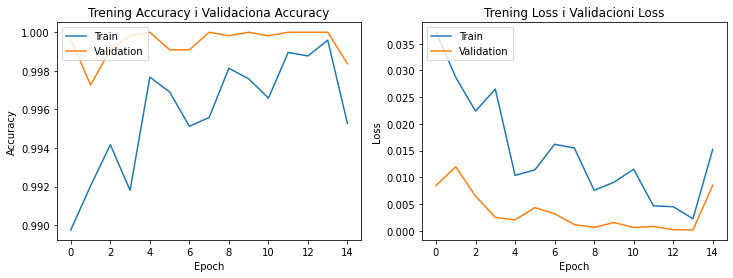

In [28]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Validaciona Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Validacioni Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()